In [1]:
import json
import itertools
from fractions import Fraction
import numpy as np
import pandas
import seaborn as sns

from textwrap import wrap

import ipykernel
import matplotlib
    
import matplotlib.pyplot as plt

#GUI elements
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

In [2]:
%run logic.ipynb
%run participant.ipynb


----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK


In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
#Example JSON
root_question = {'qid':0,
'question': 'Q1',
'answers': ['A','B','C'],
'probability': ['1/3','1/3','1/3']}

follow_up_1 = {'qid':1,
'question': 'Follow-up...',
'answers': ['1','2','3','4','5'],
'probability': ['1/5','1/5','1/5','1/5','1/5']}

paths = [[0,'C',1]]

json_poll = {
    'roots': [root_question],
    'children': [follow_up_1],
    'paths':paths,
    'truth':['1/4']
}

In [5]:
answer_dist = {}
poll_name = ''

In [6]:
def loadJSON(change):
    global json_poll
    global poll_name
    poll_name = file_selection.value 
    json_poll = getJSON(poll_name)

def getJSON(name):
    # Read JSON from files
    json_file = open(name, 'r')
    json_content = json_file.read()
    return json.loads(json_content)

In [7]:
def update_dist(change):
    
    current_accordion = dist_accordion.children[dist_accordion.selected_index]
    dropdown = current_accordion.children[1]
    active_sliders = current_accordion.children[2].children
    
    if dropdown.value != 'Custom':
        shape_slider = current_accordion.children[3]

        # Draw values from dist
        values = distMap[dropdown.value](len(active_sliders),shape_slider.value)

        for slider in active_sliders:

            index = active_sliders.index(slider)
            slider.value = np.round(values[index], decimals=sliders_precision)
            
     
    #Save values
    for slider in active_sliders:
        index = active_sliders.index(slider)
        answer_dist[dist_accordion.selected_index][index][dropdown.value] = slider.value

        

In [8]:
def dropdown_action(change):
    current_accordion = dist_accordion.children[dist_accordion.selected_index]
    dropdown = current_accordion.children[1]
    shape_slider = current_accordion.children[3]
    shape_slider.hold_trait_notifications()

    # Update the shape slider according to the chosen distribution
    if(dropdown.value is 'Uniform' or dropdown.value is 'Custom'):
        shape_slider.disabled=True
        shape_slider.layout.visibility='hidden'
    else:

        if(dropdown.value is 'Geom'):
            shape_slider.step = 0.01
            shape_slider.min = 0. + shape_slider.step
            shape_slider.max = 1.
            shape_slider.value = 0.5
        elif(dropdown.value is 'Logser'):
            shape_slider.step = 0.01
            shape_slider.min = 0. + shape_slider.step
            shape_slider.max = 1. - shape_slider.step
            shape_slider.value = 0.6
        elif(dropdown.value is 'Planck'):
            shape_slider.step = 0.01
            shape_slider.min = 0. + shape_slider.step
            shape_slider.max = 1.
            shape_slider.value = 0.51
        elif(dropdown.value is 'Zipf'):
            shape_slider.max = 10.
            shape_slider.step = 0.01
            shape_slider.min = 1. + shape_slider.step
            shape_slider.value = 1.5

        shape_slider.disabled=False
        shape_slider.layout.visibility='visible'
        
    #Reset values
    active_sliders = current_accordion.children[2].children   
     
    for slider in active_sliders:
        index = active_sliders.index(slider)
        
        val = dropdown.value
        if val not in answer_dist[dist_accordion.selected_index][index].keys():
            update_dist(None)
        slider.value = answer_dist[dist_accordion.selected_index][index][val]

In [9]:
%run gui_components.ipynb

<IPython.core.display.Javascript object>

In [10]:
display(widgets.HTML('<center><h1> Choose Parameters'))
load_button.on_click(loadJSON)
display(start_tab)

HTML(value=u'<center><h1> Choose Parameters')

VGFiKGNoaWxkcmVuPShIQm94KGNoaWxkcmVuPShWQm94KGNoaWxkcmVuPShMYWJlbCh2YWx1ZT11J0lucHV0IEpTT046JyksIFNlbGVjdChpbmRleD0yLCBvcHRpb25zPSgncHVyY2hhc2UuanPigKY=


In [11]:
load_button.click()

In [12]:
poll_info = parsePoll(json_poll)
subtrees=poll_info['subtrees']
matrices=poll_info['matrices']
lookup = poll_info['lookup']
ps = poll_info['paths']
epsilons = poll_info['epsilons']

In [13]:
# Distribution sliders per question (non-flattened)
children = []

c = 0
order = {}
for question in subtrees:
    for subquestion in subtrees[question]:
        count = 0
        dist_accordion.set_title(c, 'Question: '+subquestion['question'])
        order[subquestion['qid']] = c
        html = widgets.HTML('<h3>Choose weight distribution...</h3>')
        to_add = []
        answer_dist[c] = {}
        
        
        for answer in subquestion['answers']:
            probability = subquestion['probability'][count]
            to_add.append(widgets.FloatSlider(
                value=probability,
                min=0,
                max=1.0,
                step=0.01,
                description=answer,
                disabled=False,
                continuous_update=False,
                orientation='vertical',
                readout=True,
                readout_format='.1f',
            ))
            answer_dist[c][count] = {'Custom': probability}
            count +=1
        
        #Components
        _shape_slider = widgets.FloatSlider(min=0., max=5., step=0.1, value=0., continuous_update=False, description='Shape', disabled=True) 
        _dropdown = widgets.Dropdown(options=dists, value='Custom', description='Distribution:', disabled=False)
        _button = widgets.Button(description='Update weights', icon='fa-bar-chart', button_style='success')
        
        #Actions
        _button.on_click(update_dist)
        _dropdown.observe(dropdown_action)
        
        contents =[html, _dropdown, widgets.HBox(to_add),_shape_slider, _button]
        children.append( widgets.VBox(contents))
        c += 1
        
dist_accordion.children = children
dist_box = widgets.VBox([dist_accordion])

In [14]:
display(widgets.HTML('<center><h1> Set <i>True</i> Answer Distribution</h1></center>'))
display(dist_accordion)
dropdown_action(None)

HTML(value=u'<center><h1> Set <i>True</i> Answer Distribution</h1></center>')

QWNjb3JkaW9uKGNoaWxkcmVuPShWQm94KGNoaWxkcmVuPShIVE1MKHZhbHVlPXUnPGgzPkNob29zZSB3ZWlnaHQgZGlzdHJpYnV0aW9uLi4uPC9oMz4nKSwgRHJvcGRvd24oZGVzY3JpcHRpb27igKY=


In [15]:
selected = {}
for question in subtrees:
    selected[question] = {}
    for subquestion in subtrees[question]:
        selected[question][subquestion['qid']] = []
        qid = order[subquestion['qid']]
        current_box = dist_accordion.children[qid].children
        current_dropdown = current_box[1]
        current_sliders = current_box[2].children
  
        #NORMALIZE SLIDER VALUES BEFORE MOVING ON
        normalize_by = 0
        for slider in current_sliders:
            index = current_sliders.index(slider)
            normalize_by+= answer_dist[qid][index][current_dropdown.value]

        for slider in current_sliders:
            index = current_sliders.index(slider)
            value = answer_dist[qid][index][current_dropdown.value]/normalize_by
            selected[question][subquestion['qid']].append(value)
            


# Find matching path
# {qid: (Path, Fraction)}

In [16]:
# Turn slides to JSON, then parse to find path-weight pairs

#FIXME: Don't overwrite actual json_poll, do deep copy!
 
dist_poll = getJSON(poll_name)

for question in subtrees:
    root = filter(lambda x: x['qid']==question, dist_poll['roots'])[0]
    root['probability'] = selected[question][question]
    
    for subquestion in subtrees[question]:
        # Roots have already been added, will also return empty list so ignore
        question_struct = filter(lambda x: x['qid']==subquestion['qid'], dist_poll['children'])
        if len(question_struct) > 0:
            question_struct[0]['probability'] = selected[question][subquestion['qid']]
            
weights = parsePoll(dist_poll)['weighted_paths']

In [17]:
# Add widget

In [26]:
participants = []
n = 10000
participant_budget = 40
runs = 10
data = {}

#Populate data structure
for question in subtrees.keys():
    data[question]={'error_relative': {}, 'error_absolute':{}}

    for alternative in ps[question]:
        data[question]['error_relative'][pathToKey(alternative)] = []
        data[question]['error_absolute'][pathToKey(alternative)] = []

#TODO: Loop x times for confidence
for run in range(0, runs):
    raw_responses = []
    real_answers = []

    #Initialize partitipants and run RR
    for i in range(0, n):
        new_participant = Participant(participant_budget, json_poll)
        new_participant.setMatrices(matrices)
        new_participant.setEpsilons(epsilons)
        new_participant.createAnswers(weights)

        real_answers.append(dict(new_participant.getAnswer())) #Beware: deep copy required!
        raw_responses.append(new_participant.randomizedResponse())

        participants.append(new_participant)

    # Parse responses
    lists_responses = {}
    lists_answer = {}
    for question in subtrees.keys():
        lists_responses[question] = map(lambda x: pathToKey(x[question]), raw_responses)
        lists_answer[question] = map(lambda x: pathToKey(x[question]), real_answers)

    response_frame = pd.DataFrame(lists_responses)
    response_frequency = {}
    answer_frame = pd.DataFrame(lists_answer)
    answer_frequency = {}

    #Count occurences
    for question in subtrees.keys():
        response_frequency[question] = {}
        answer_frequency[question] = {}

        to_match = pd.unique(response_frame[question])
        for match in to_match:
            response_frequency[question][match] = len(response_frame[response_frame[question]==match])
            answer_frequency[question][match] = len(answer_frame[answer_frame[question]==match])

    
            
    #Filter with Bayes' theorem
    for question in response_frequency.keys():
        #P(True)
        p_true = Fraction(lookup[question]['truth'])

        #Bayes' theorem: p(A|True) = p(True|A)*p(A) / p(True)
        for alternative in response_frequency[question].keys():
            transition = (alternative, alternative)
            #p(True|A), Probability of not changing answer
            p_true_given_a = matrices[question][transition]
            #p(A), Actual responses
            p_a = Fraction((response_frequency[question][alternative]),len(participants)) #Convert to %

            #p(A|True) = p(True|A)*p(A) / p(True)
            p_a_given_true = (p_true_given_a*p_a)/p_true

            # Save percentage and use on pop!
            true_a = float(p_a_given_true*p_true)*response_frequency[question][alternative]
            
            ### Calculate error from ground truth
            real_percentage = float(answer_frequency[question][alternative])/len(participants)

            abs_diff = abs(p_a_given_true-real_percentage)
            rel_diff = 100
            if real_percentage != 0:
                rel_diff = abs_diff/real_percentage
            
            data[question]['error_relative'][alternative].append(rel_diff)
            data[question]['error_absolute'][alternative].append(abs_diff)

In [29]:
#TODO: parse back from paths to alternatives!
#TODO: display graphs

In [30]:
display(widgets.HTML('<h1><b><u> Results'))

HTML(value=u'<h1><b><u> Results')

HTML(value=u'<h2> Boxplots for question: Blood type?')

HTML(value=u'<h3><i> Relative error')

/home/boel/chalmers/research/randori/Randori/miniconda/envs/notebook/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/boel/chalmers/research/randori/Randori/miniconda/envs/notebook/lib/python2.7/site-packages/seaborn/categorical.py:450: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


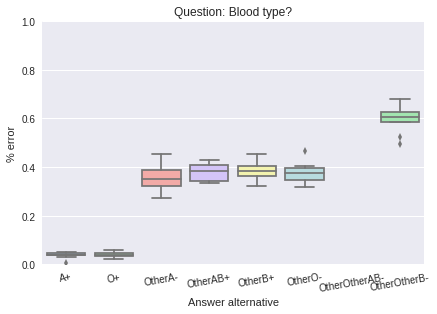

HTML(value=u'<h3><i> Absolute error')

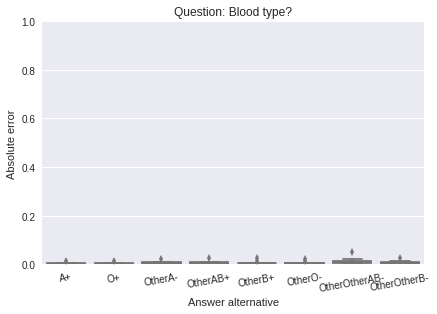

HTML(value=u'<h2> Boxplots for question: Specify...')

HTML(value=u'<h3><i> Relative error')

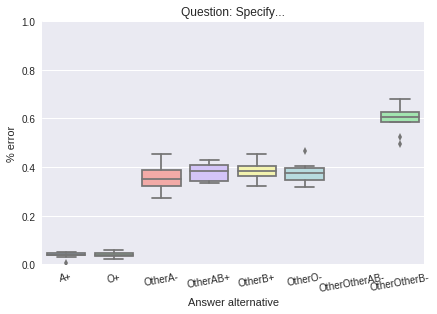

HTML(value=u'<h3><i> Absolute error')

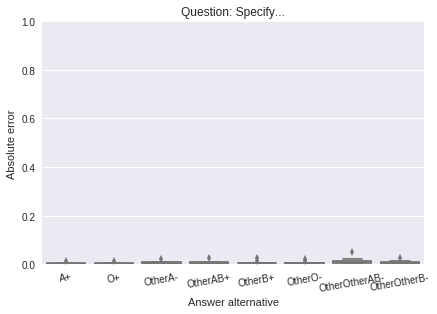

HTML(value=u'<h2> Boxplots for question: Specify further...')

HTML(value=u'<h3><i> Relative error')

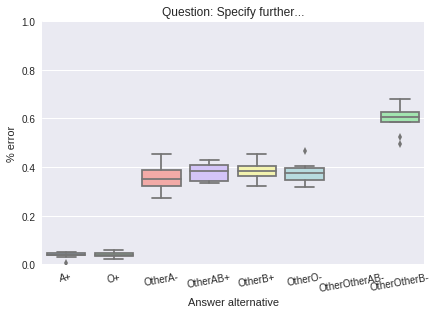

HTML(value=u'<h3><i> Absolute error')

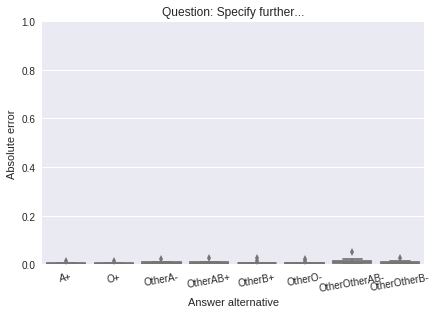

HTML(value=u'<h2><b> SUMMARY')

HTML(value=u'<h3> Error: error_absolute')

,A+,O+,OtherA-,OtherAB+,OtherB+,OtherO-,OtherOtherAB-,OtherOtherB-
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.003973,0.003703,0.006989,0.007259,0.007356,0.007198,0.013813,0.008514
std,0.003887,0.003387,0.006216,0.006928,0.006970,0.006811,0.014358,0.007262
min,0.000247,0.000871,0.002345,0.002357,0.002571,0.002647,0.004504,0.003042
25%,0.001611,0.001956,0.003088,0.003146,0.003608,0.003200,0.005967,0.003841
50%,0.002686,0.002539,0.004020,0.004341,0.004863,0.004322,0.008299,0.005242
75%,0.004919,0.003894,0.009204,0.008290,0.006869,0.007035,0.013685,0.010248
max,0.013567,0.012500,0.022393,0.025147,0.025340,0.024093,0.051390,0.025935


HTML(value=u'<h3> Error: error_relative')

,A+,O+,OtherA-,OtherAB+,OtherB+,OtherO-,OtherOtherAB-,OtherOtherB-
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.038659,0.039847,0.359215,0.379107,0.384221,0.376540,2.697330,0.599356
std,0.012611,0.012382,0.053162,0.037539,0.042343,0.042669,0.287212,0.056780
min,0.007302,0.021105,0.272541,0.335460,0.321672,0.318106,2.421685,0.494000
25%,0.039338,0.034346,0.324080,0.341550,0.365191,0.348804,2.524595,0.586835
50%,0.040251,0.039210,0.351037,0.382234,0.383027,0.375999,2.660588,0.605974
75%,0.046057,0.044734,0.387619,0.408140,0.403468,0.395926,2.793341,0.627391
max,0.051176,0.059716,0.453211,0.430769,0.451897,0.468118,3.403311,0.679573


HTML(value=u'<h2> Boxplots for question: 1 or 2?')

HTML(value=u'<h3><i> Relative error')

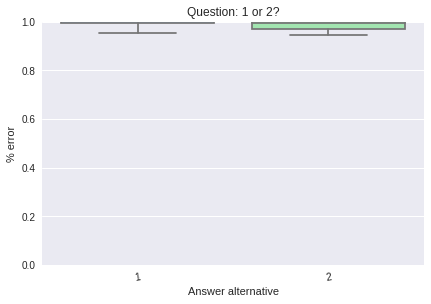

HTML(value=u'<h3><i> Absolute error')

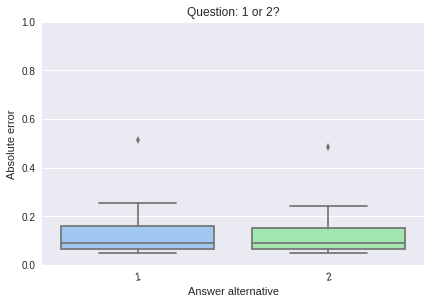

HTML(value=u'<h2><b> SUMMARY')

HTML(value=u'<h3> Error: error_absolute')

,1,2
count,10.000000,10.000000
mean,0.148928,0.143969
std,0.143935,0.133375
min,0.048850,0.051150
25%,0.065611,0.063854
50%,0.091745,0.091588
75%,0.160638,0.151863
max,0.515800,0.484200


HTML(value=u'<h3> Error: error_relative')

,1,2
count,10.000000,10.000000
mean,1.010113,0.990350
std,0.031398,0.031192
min,0.953488,0.946577
25%,0.996080,0.968681
50%,1.002783,0.997184
75%,1.031683,1.003881
max,1.054590,1.047909


HTML(value=u'<h2> Boxplots for question: Q3?')

HTML(value=u'<h3><i> Relative error')

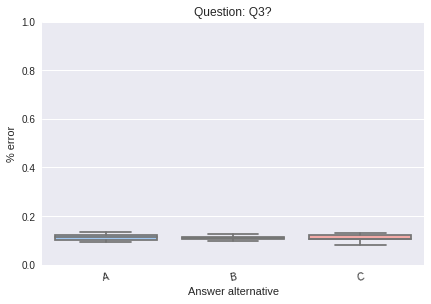

HTML(value=u'<h3><i> Absolute error')

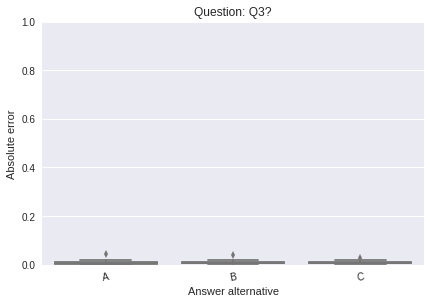

HTML(value=u'<h2><b> SUMMARY')

HTML(value=u'<h3> Error: error_absolute')

,A,B,C
count,10.000000,10.000000,10.000000
mean,0.011737,0.010858,0.009949
std,0.012699,0.010566,0.007724
min,0.004092,0.003665,0.003290
25%,0.004474,0.005177,0.005012
50%,0.006543,0.007026,0.006802
75%,0.011448,0.010587,0.012687
max,0.044922,0.038333,0.027856


HTML(value=u'<h3> Error: error_relative')

,A,B,C
count,10.000000,10.000000,10.000000
mean,0.113219,0.111086,0.109225
std,0.014010,0.008275,0.014020
min,0.093239,0.097055,0.082978
25%,0.101918,0.107630,0.104357
50%,0.113476,0.111446,0.106390
75%,0.123194,0.115915,0.120631
max,0.133976,0.124335,0.129203


<Figure size 432x288 with 0 Axes>

In [31]:
fig = plt.figure()
for question in subtrees:
    for subquestion in subtrees[question]:
        display(widgets.HTML('<h2> Boxplots for question: '+subquestion['question']))
        fig.clear()
        plt.xticks(fontsize = label_font_size, ha='center', rotation=xlabel_rotation)
        plt.ylim(ylimit)
        plt.tight_layout()
        
        display(widgets.HTML('<h3><i> Relative error'))
        ax1 = fig.add_subplot(1, 1, 1)
        ax1.set_title('\n'.join(wrap('Question: '+subquestion['question'], 50)))
        ax1.set_xlabel('Answer alternative')
        ax1.set_ylabel('% error')
        ax1.set_ylim(ylimit)
        
        sns.boxplot(ax=ax1,data=pd.DataFrame(data[question]['error_relative']),palette='pastel')
        display(fig)
        fig.clear()

        display(widgets.HTML('<h3><i> Absolute error'))
        
        plt.xticks(fontsize = label_font_size, ha='center', rotation=xlabel_rotation)
        plt.ylim(ylimit)
        plt.tight_layout()
        
        ax2 = fig.add_subplot(1, 1, 1)
        ax2.set_title('\n'.join(wrap('Question: '+subquestion['question'], 50)))
        ax2.set_xlabel('Answer alternative')
        ax2.set_ylabel('Absolute error')
        ax2.set_ylim(ylimit)
        sns.boxplot(ax=ax2,data=pd.DataFrame(data[question]['error_absolute']),palette='pastel')

        display(fig)
        fig.clear()
        

    display(widgets.HTML('<h2><b> SUMMARY'))
    for error in data[question].keys():
        
        display(widgets.HTML('<h3> Error: '+error)) 

        display(pd.DataFrame(data[question][error]).describe())

    